# Sampling from encoded space

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time # used to evaluate time performances
import os
import random
from tqdm import tqdm, tnrange

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
#%% Define the network architecture
class Autoencoder(nn.Module):
    def __init__(self, encoded_space_dim, dropout=0.2):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout(dropout)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Dropout(dropout)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:
#%% Define paths

data_root_dir = '../datasets'

#%% Create dataset

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset  = MNIST(data_root_dir, train=False, download=False, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [4]:
encoded_space_dim = 2
net = Autoencoder(encoded_space_dim, dropout=0)
# load trained weights
net.load_state_dict(torch.load('params/gaussian_net_params_'+str(encoded_space_dim)+'.pth', 
                               map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
batch = next(iter(test_loader))
with torch.no_grad():
    enc = net.encode(batch[0])
print('enc.shape: ', enc.shape)

enc.shape:  torch.Size([512, 2])


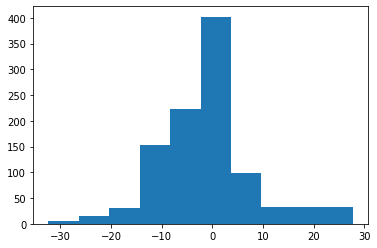

In [6]:
_ = plt.hist(enc.numpy().flatten())

Looking at the data we should sample approximately from [-30,30]x[-30,30]. However this is a very crude method and I prefer something more automatic and natural.

In [7]:
# get raw data
labels = test_dataset.targets
images = (test_dataset.data/255.).view(-1,1,28,28).float() # MNIST dataset.data is a bit messed up

In [8]:
# divide images in classes
digit_classes = []
for i in range(10):
    i_mask = (labels == i)
    i_images = images[i_mask]
    print("Number of images of digit %d : %d"%(i,len(i_images)))
    digit_classes.append(i_images)

Number of images of digit 0 : 980
Number of images of digit 1 : 1135
Number of images of digit 2 : 1032
Number of images of digit 3 : 1010
Number of images of digit 4 : 982
Number of images of digit 5 : 892
Number of images of digit 6 : 958
Number of images of digit 7 : 1028
Number of images of digit 8 : 974
Number of images of digit 9 : 1009


In [9]:
centroids = []
for i in range(len(digit_classes)):
    with torch.no_grad():
        enc = net.encode(digit_classes[i])
    centroid = enc.mean(axis=0).view(1,2)
    centroids.append(centroid)
centroids = torch.cat(centroids)
print("centroids.shape: ", centroids.shape)

centroids.shape:  torch.Size([10, 2])


In [10]:
def sampling_enc_space(centroids, n_samples):
    """
    Uniform sampling in the encoded space.
    """
    x_max = centroids.max(axis=0).values.numpy()
    x_min = centroids.min(axis=0).values.numpy()
    u = np.random.random((n_samples,centroids.shape[1]))*(x_max-x_min)+x_min
    x = torch.Tensor(u)
    return x

In [11]:
def grid_sampling_enc_space(centroids, n_samples):
    """
    Grid sampling in the encoded space. Used for 3D plot.
    """
    x_max = centroids.max(axis=0).values.numpy()
    x_min = centroids.min(axis=0).values.numpy()
    axis1 = np.linspace(x_min[0], x_max[0], int(np.sqrt(n_samples)))
    axis2 = np.linspace(x_min[1], x_max[1], int(np.sqrt(n_samples)))
    broad_axis1 = np.stack([axis1,np.ones(int(np.sqrt(n_samples)))], axis=1)
    broad_axis2 = np.stack([np.ones(int(np.sqrt(n_samples))), axis2], axis=1)
    x = (broad_axis1[:,np.newaxis,:]*broad_axis2[np.newaxis,:,:]).reshape(-1,2)
    x = torch.Tensor(x)
    return x, axis1, axis2, int(np.sqrt(n_samples))**2

In [12]:
x = sampling_enc_space(centroids, 20000)

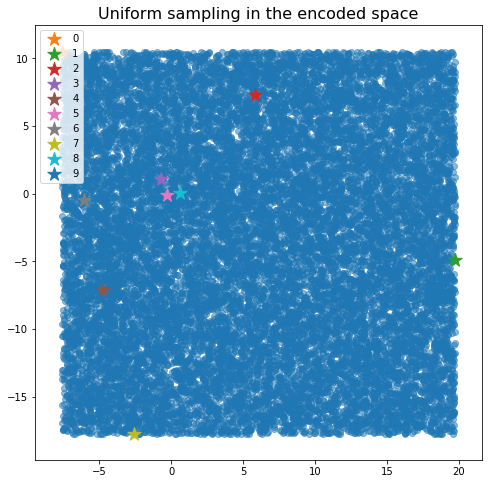

In [13]:
# just for 2D
plt.figure(figsize=(8,8))
plt.scatter(x[:,0],x[:,1], alpha=0.5)
for i in range(len(centroids)):
    plt.scatter(centroids[i,0], centroids[i,1], marker='*', s=200, label='%d'%i)
plt.title("Uniform sampling in the encoded space", fontsize=16)
plt.legend()
plt.show()

In [14]:
def sampling_images(net, centroids, n_samples, digits = None):
    """
    Note: digits must be a list or a numpy array of integers
    """
    if digits is not None:
        digits = np.array(digits)
        centroids = centroids[digits]
    
    x = sampling_enc_space(centroids, n_samples)
    with torch.no_grad():
        img = net.decode(x)
    return img

In [15]:
n_samples = 10
img = sampling_images(net, centroids, n_samples)

In [16]:
def show_digit(img):
    plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
    plt.show()
    return

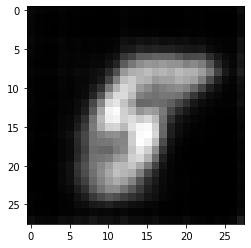

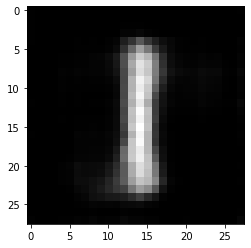

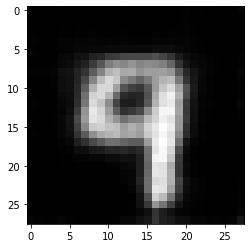

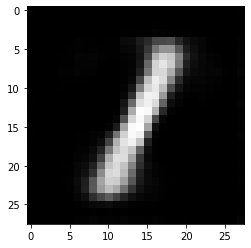

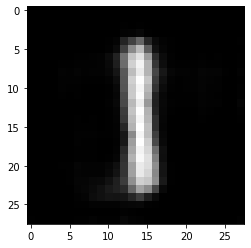

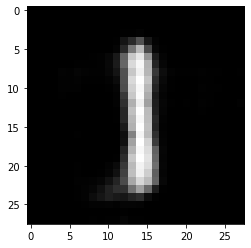

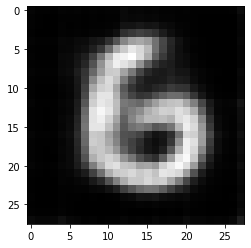

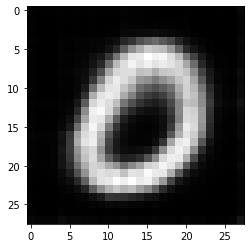

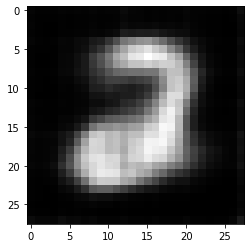

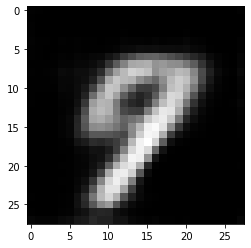

In [17]:
for i in range(n_samples):
    show_digit(img[i])

# Smoothness of the encoded space - 2D case

In [18]:
n_samples = 10000

In [19]:
def distance_map(net, centroids, n_samples):
    
    #useful quantities
    shape = centroids.shape
    enc_dim = centroids.shape[1]
    
    # sample points in the plane
    x, axis1, axis2, n_samples = grid_sampling_enc_space(centroids, n_samples)
    
    # get correpsonding images
    with torch.no_grad():
        img = net.decode(x)
        centroids_img = net.decode(centroids)

    # get for each x the nearest centroid
    d_encoded = (x.view(n_samples,1,enc_dim)-centroids.view((1,)+shape))**2
    d_encoded = d_encoded.numpy().sum(axis=2)
    nearest_c_index = np.argmin(d_encoded, axis=1)
    
    # get for each x the output of the nearest centroid
    centroids_img = centroids_img[nearest_c_index]
    
    # compute distance between images
    D_real_space = (img-centroids_img)**2
    D_real_space = D_real_space.view(n_samples,-1).sum(axis=1)
    
    return x, axis1, axis2, D_real_space

In [20]:
x, axis1, axis2, D_real_space = distance_map(net, centroids, n_samples)
x = x.numpy()
D_real_space = D_real_space.numpy()
centroids_np = centroids.numpy()

In [21]:
# just for plotting, real z coordinates are 0
eps = 5
idx1 = np.argmin((centroids_np[:,0].reshape([10,1])-axis1[np.newaxis,:])**2, axis=1)
idx2 = np.argmin((centroids_np[:,1].reshape([10,1])-axis2[np.newaxis,:])**2, axis=1)
z_centroids = D_real_space.reshape([len(axis1),-1])[idx1,idx2] + eps

In [22]:
######################
# requirement
# ! pip install plotly
######################
import plotly as py # main class
import plotly.graph_objs as go # graphical objects
py = py.offline
py.init_notebook_mode(connected=True)


trace1 = go.Surface(x=axis1, y=axis2, z=D_real_space.reshape([len(axis1),-1]).T)

trace2 = go.Scatter3d(x=centroids_np[:,0], y=centroids_np[:,1], z=z_centroids, 
                    mode='markers', text=[str(i) for i in range(10)], 
                    hoverinfo='text',
                    marker=dict(size=5, line=dict(width=0)))

data = [trace1, trace2]
scene=dict(camera=dict(), #the default values are 1.25, 1.25, 1.25
           xaxis=dict(),
           yaxis=dict(),
           zaxis=dict(),
           #aspectmode='cube', #this string can be 'data', 'cube', 'auto', 'manual'
           #a custom aspectratio is defined as follows:
           aspectratio=dict(x=1, y=1, z=1),
           #annotations = annotations,
           )
layout = go.Layout(autosize=False, scene=scene)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),)
#fig.update_traces(textposition='top center')
py.iplot(fig)

**Smoothness** = small movement in the encoded space translates in a small change in the output space <br>
**Homogeneity** = a point that in the encoded space is equidistant from 2 other points, should be equidistant to them also in the output space

**Interpretation and observations:**

To test the smoothness and the homogeneity of the encoded space I defined a function D(x,y) that is equal to the square distance in the output space from the image of the nearest centroid in the encoded space.

For example if I take the centroid of the digit 1, the nearest centroid is the same as the point itself, so its function D will be 0. Now if we take the nearest centroid different from 1 and we move toward it, the function D will increase because we are changing the optput and the distance is non-negative. When the point selected is halfway between the two nearest centroids we naturally reach a maximum, but it can be continuous or discontinuous, depending on whether the distance in the output space from the two centroids is the same or not.

Looking from above the plot it's possible to see the "basins of attraction" of all the different digits, delimited by the ridges. The orange dots represent the centroids of the 10 digits and hovering over them is possible to see which digit corresponds to each of them. We can see that 4 and 9 are mapped adjacent to one another and so are 3, 5 and 8. Also it's possible to see that the 2D encoded space of an autoencoder is smooth but not homogeneous, since ridges are not smooth.